In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os, os.path
import re
import glob
import pickle
import numpy
from scipy.misc import logsumexp
from scipy import interpolate
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleIsochroneApprox
from galpy.actionAngle import actionAngleTorus
from galpy.orbit import Orbit
from galpy.df import streamdf
from galpy.util import bovy_plot, bovy_conversion, bovy_coords, save_pickles
import seaborn as sns
import MWPotential2014Likelihood
import pal5_util
_REFR0, _REFV0= MWPotential2014Likelihood._REFR0, MWPotential2014Likelihood._REFV0
ro, vo= _REFR0, _REFV0
%pylab inline
from matplotlib import cm
save_figures= False

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))

Populating the interactive namespace from numpy and matplotlib


# Exploration of the Milky Way's dark halo shape using the Palomar 5 stream

## The data

In [3]:
pos_radec, rvel_ra= pal5_util.pal5_data()

## Some convenience functions

In [4]:
width_trailing= pal5_util.width_trailing

In [5]:
def plot_data_add_labels(radeconly=False,rvonly=False,color=sns.color_palette()[2]):
    if not radeconly and not rvonly: subplot(1,2,1)
    if not rvonly:
        xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
        ylabel(r'$\mathrm{Dec}\,(\mathrm{degree})$')
        xlim(250.,220.)
        ylim(-5.,9.)
        bovy_plot._add_ticks()
        errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
                 ls='none',marker='o',color=color)
    if radeconly: return None
    if not rvonly: subplot(1,2,2)
    xlabel(r'$\mathrm{RA}\,(\mathrm{degree})$')
    ylabel(r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$')
    xlim(250.,220.)
    ylim(-80.,0.)
    bovy_plot._add_ticks()
    errorbar(rvel_ra[rvel_ra[:,0] > 230.5,0],rvel_ra[rvel_ra[:,0] > 230.5,1],
             yerr=rvel_ra[rvel_ra[:,0] > 230.5,2],
             ls='none',marker='o',color=color)
    return None
def add_colorbar(vmin,vmax,clabel,save_figures=False):
    fig= pyplot.gcf()
    if save_figures:
        cbar_ax = fig.add_axes([0.9,0.135,0.025,0.815])
    else:
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.975, 0.13, 0.025,0.78])
    sm = pyplot.cm.ScalarMappable(cmap=cmap,norm=pyplot.Normalize(vmin=vmin,vmax=vmax))
    sm._A = []
    cbar= fig.colorbar(sm,cax=cbar_ax,use_gridspec=True,format=r'$%.1f$')
    cbar.set_label(clabel)
    return None

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))



## The fiducial model

The fiducial model assumes a spherical halo, with the best-fit parameters from fitting to the MWPotential2014 data

In [6]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
ro,vo= _REFR0,_REFV0
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.0,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
aAI= actionAngleIsochroneApprox(pot=pot,b=0.8)
aAT= actionAngleTorus(pot=pot,tol=0.001)
sigv= 0.4

In [7]:
sdf_trailing= streamdf(sigv/vo,progenitor=prog,
                       pot=pot,aA=aAI,useTM=aAT,
                       approxConstTrackFreq=True,
                       leading=False,nTrackChunks=21,
                       tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                       ro=ro,vo=vo,R0=ro,
                       vsun=[-11.1,vo+24.,7.25],
                       custom_transform=pal5_util._TPAL5)
sdf_leading= streamdf(sigv/vo,progenitor=prog,
                      pot=pot,aA=aAI,useTM=aAT,
                      approxConstTrackFreq=True,
                      leading=True,nTrackChunks=21,
                      tdisrupt=5./bovy_conversion.time_in_Gyr(vo,ro),
                      ro=ro,vo=vo,R0=ro,
                      vsun=[-11.1,vo+24.,7.25],
                      custom_transform=pal5_util._TPAL5)

In [8]:
threshold= 0.3
print "Angular length: %f deg (leading,trailing)=(%f,%f) deg" % \
    (sdf_leading.length(ang=True,coord='customra',threshold=threshold)\
    +sdf_trailing.length(ang=True,coord='customra',threshold=threshold),
     sdf_leading.length(ang=True,coord='customra',threshold=threshold),
     sdf_trailing.length(ang=True,coord='customra',threshold=threshold))
#print "Angular width (FWHM): %f arcmin" % (width_trailing(sdf_trailing))

Angular length: 71.069607 deg (leading,trailing)=(43.798465,27.271142) deg


In [9]:
trackRADec_trailing=\
  bovy_coords.lb_to_radec(sdf_trailing._interpolatedObsTrackLB[:,0],
                          sdf_trailing._interpolatedObsTrackLB[:,1],
                          degree=True)
trackRADec_leading=\
  bovy_coords.lb_to_radec(sdf_leading._interpolatedObsTrackLB[:,0],
                          sdf_leading._interpolatedObsTrackLB[:,1],
                          degree=True)
lb_sample_trailing= sdf_trailing.sample(n=10000,lb=True)
lb_sample_leading= sdf_leading.sample(n=10000,lb=True)
radec_sample_trailing= bovy_coords.lb_to_radec(lb_sample_trailing[0],
                                               lb_sample_trailing[1],
                                               degree=True)
radec_sample_leading= bovy_coords.lb_to_radec(lb_sample_leading[0],
                                              lb_sample_leading[1],
                                              degree=True)

What is the observed length?

In [10]:
# Pretend to find the length
peak_dens= sdf_trailing.density_par(0.1,coord='customra')
trackxieta_trailing=\
    pal5_util.radec_to_pal5xieta(trackRADec_trailing[:,0],
                                 trackRADec_trailing[:,1],degree=True)
theta_end= numpy.interp(15.,trackxieta_trailing[:,0],
                    sdf_trailing._interpolatedThetasTrack)
end_dens= sdf_trailing.density_par(theta_end,coord='customra')
print "Pal 5's trailing tail is at least %.1f degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree" \
    % sdf_trailing.length(threshold=end_dens/peak_dens,coord='customra',ang=True)

Pal 5's trailing tail is at least 21.3 degree long, in good agreement with Carlberg et al. (2012)'s 23.2 degree


<Container object of 3 artists>

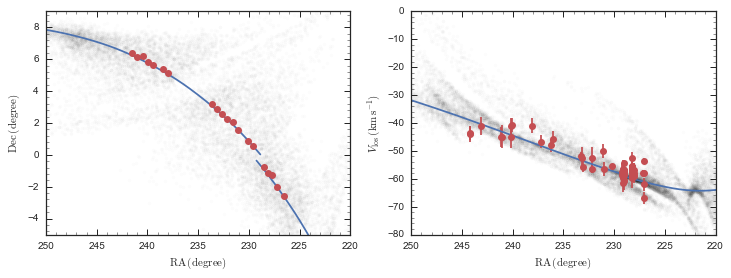

In [11]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    trackRADec_trailing[:,1],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-5.,9.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$\mathrm{Dec}\,(\mathrm{degree})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    trackRADec_leading[:,1],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],radec_sample_trailing[:,1],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],radec_sample_leading[:,1],'k.',
     alpha=0.01,zorder=0)
errorbar(pos_radec[:,0],pos_radec[:,1],yerr=pos_radec[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])
subplot(1,2,2)
bovy_plot.bovy_plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    xrange=[250.,220.],
                    yrange=[-80.,0.],
                    xlabel=r'$\mathrm{RA}\,(\mathrm{degree})$',
                    ylabel=r'$V_{\mathrm{los}}\,(\mathrm{km\,s}^{-1})$',
                   gcf=True)
bovy_plot.bovy_plot(trackRADec_leading[:,0],
                    sdf_leading._interpolatedObsTrackLB[:,3],
                    color=sns.color_palette()[0],
                    overplot=True)
plot(radec_sample_trailing[:,0],lb_sample_trailing[3],'k.',
     alpha=0.01,zorder=0)
plot(radec_sample_leading[:,0],lb_sample_leading[3],'k.',
     alpha=0.01,zorder=0)
errorbar(rvel_ra[:,0],rvel_ra[:,1],yerr=rvel_ra[:,2],
        ls='none',marker='o',color=sns.color_palette()[2])

The wide scatter in the black dots is because the TM calculation of the track does not do the spread well.

## The orbit of Pal 5 in different flattened and triaxial potentials

In [12]:
bf_savefilename= 'mwpot14varyc-bf.pkl'
if os.path.exists(bf_savefilename):
    with open(bf_savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        bf_params= pickle.load(savefile)
else:
    print IOError("Need to calculate best-fit potentials for different c in MWPotential2014-varyc.ipynb first")
bf_params= numpy.array(bf_params)
bf_params= bf_params[cs <= 3.]
cs= cs[cs <= 3.]

In [13]:
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
for bp,c in zip(bf_params,cs):
    pot= MWPotential2014Likelihood.setup_potential(bp,c,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

Vary $c$ along the best-fit line:

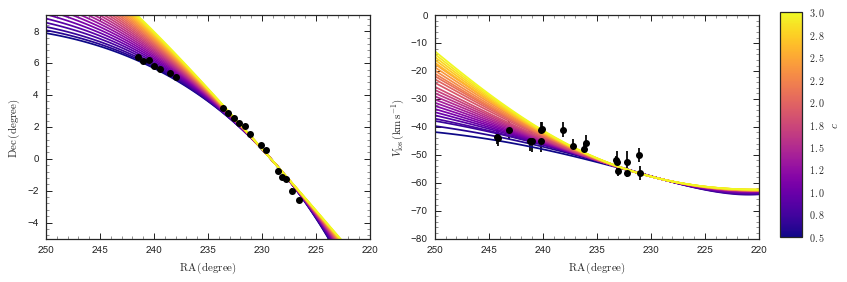

In [14]:
figsize(12,4)
cmap= cm.plasma
for c,orb,orbf in zip(cs,progs,progfs):
    tc= cmap((c-0.5)/2.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,3.,r'$c$',save_figures=False)

Vary $b$ for $c=1$ (pa=0):

In [15]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

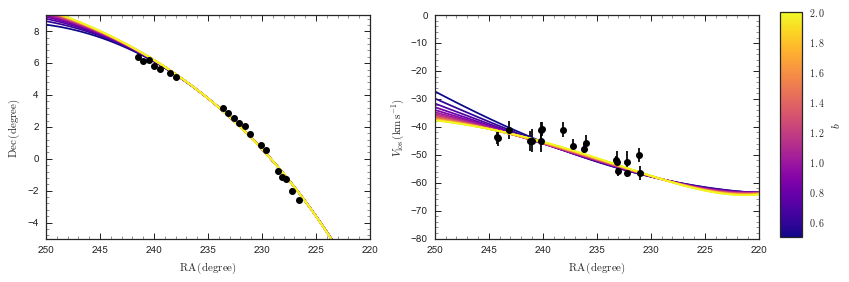

In [16]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary $b$ for $c=1$ (pa=45 degree):

In [17]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
bs= numpy.arange(0.5,2.1,0.1)
for b in bs:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo,b=b,pa=numpy.pi/4.)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

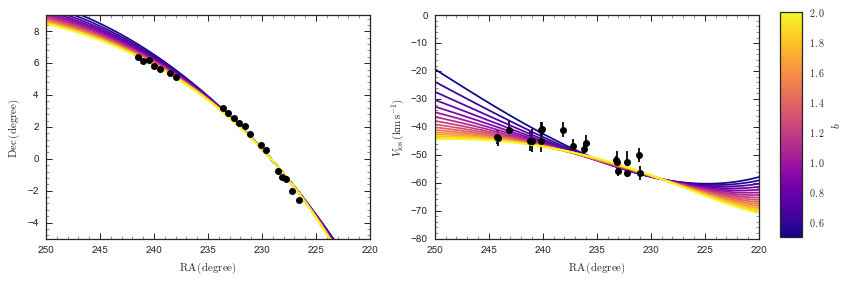

In [18]:
figsize(12,4)
cmap= cm.plasma
for b,orb,orbf in zip(bs,progs,progfs):
    tc= cmap((b-0.5)/1.5)
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(0.5,2.,r'$b$',save_figures=False)

Vary the distance:

In [19]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,3.,101)
ds= numpy.linspace(22.5,24.5,101)
for d in ds:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,d,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

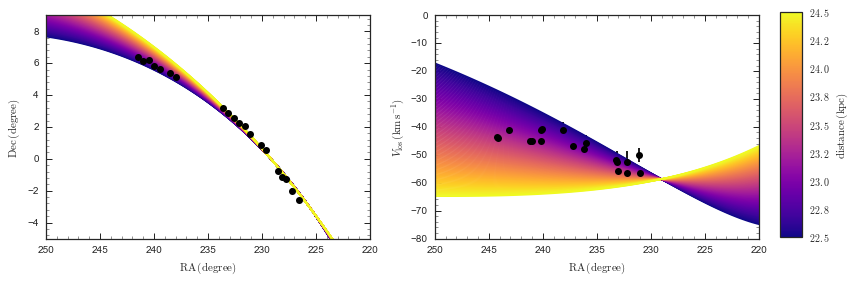

In [20]:
figsize(12,4)
cmap= cm.plasma
for d,orb,orbf in zip(ds,progs,progfs):
    tc= cmap((d-numpy.amin(ds))/(numpy.amax(ds)-numpy.amin(ds)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(ds),numpy.amax(ds),r'$\mathrm{distance}\,(\mathrm{kpc})$',save_figures=False)

Vary the proper motion parallel to the stream:

In [21]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257+2.257/2.296*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

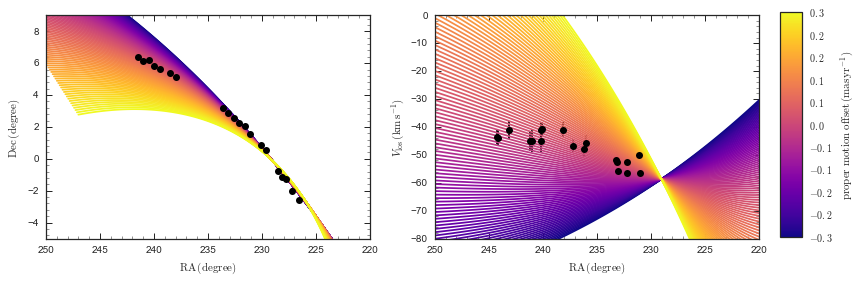

In [22]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

Vary the proper motion perpendicular to the stream:

In [23]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
progs= []
progfs= []
times= numpy.linspace(0.,2.5,101)
pms= numpy.linspace(-0.3,0.3,101)
for pm in pms:
    pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    prog.integrate(times,pot)
    progs.append(prog)
    prog= Orbit([229.018,-0.124,23.2,-2.296+pm,-2.257-2.296/2.257*pm,-58.7],radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25]).flip()
    prog.integrate(times,pot)
    prog._orb.orbit[:,1]*= -1.
    prog._orb.orbit[:,2]*= -1.
    prog._orb.orbit[:,4]*= -1.
    progfs.append(prog)

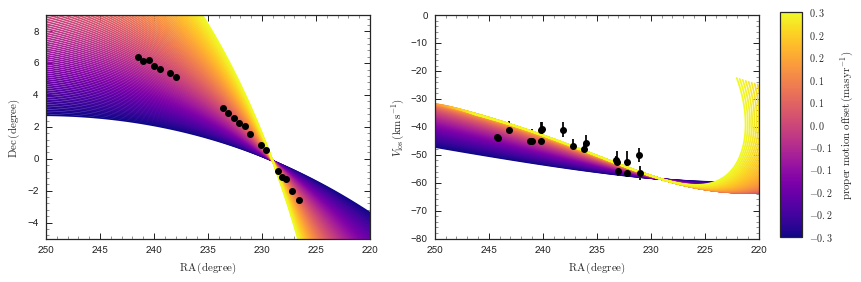

In [24]:
figsize(12,4)
cmap= cm.plasma
for pm,orb,orbf in zip(pms,progs,progfs):
    tc= cmap((pm-numpy.amin(pms))/(numpy.amax(pms)-numpy.amin(pms)))
    subplot(1,2,1)
    orb.plot(d1='ra',d2='dec',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='dec',color=tc,overplot=True)
    subplot(1,2,2)
    orb.plot(d1='ra',d2='vlos',color=tc,overplot=True)
    orbf.plot(d1='ra',d2='vlos',color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(pms),numpy.amax(pms),r'$\mathrm{proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
             save_figures=False)

## How does the track, width, and length of the Pal 5 stream vary with the potential?

We compute the stream structure for a fiducial set of parameters, to get a sense of where the track lies and how the width and length vary

In [25]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=1,useTM=False,
                                         interpcs=cs[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

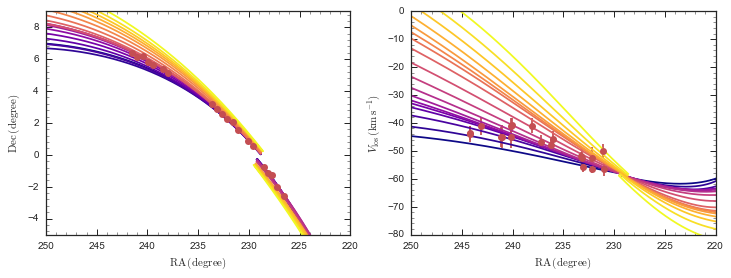

In [26]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()

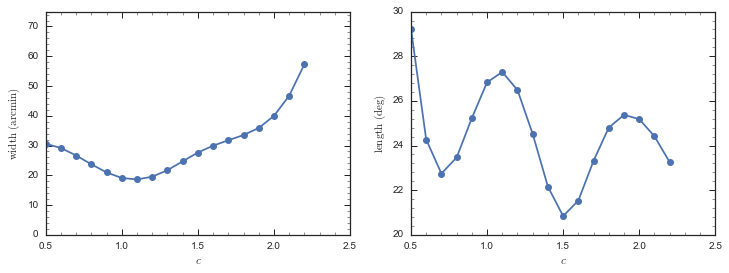

In [27]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Let's now try to make all streams 18' wide and 25 degree long:

In [28]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-constwl.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_constwl= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    interpcs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    ipw= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[4],k=3)
    ipl= interpolate.InterpolatedUnivariateSpline(cs,pal5varyc[5],k=3)
    sigv=0.4*18./ipw(interpcs)
    td=5.*25./ipl(interpcs)/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_constwl= pal5_util.predict_pal5obs(p_b15,cs,multi=8,
                                                 interpcs=interpcs,
                                                 sigv=sigv,td=td,useTM=False)
    save_pickles(savefilename,cs,pal5varyc_constwl)

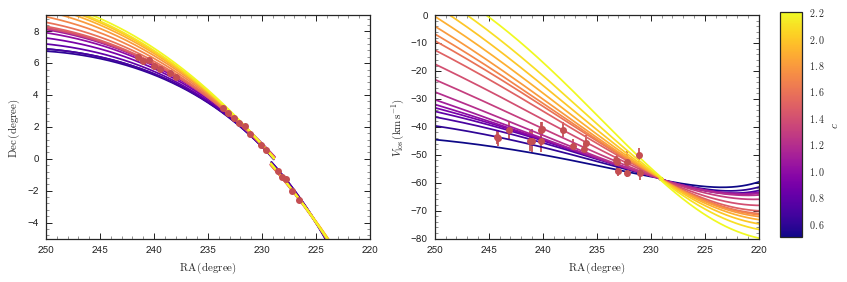

In [29]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Directly compare a subset ($c=0.5$ to $2.1$ in $0.2$ increments):

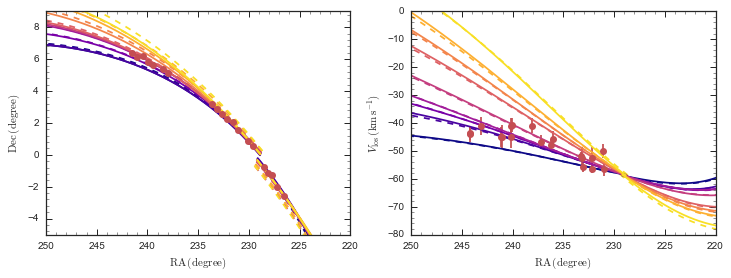

In [30]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs[::2]):
    ii*= 2
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_constwl[0][ii,:,0],
                        pal5varyc_constwl[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[1][ii,:,0],
                        pal5varyc_constwl[1][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],pal5varyc[0][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],pal5varyc[1][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_constwl[2][ii,:,0],
                        pal5varyc_constwl[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_constwl[3][ii,:,0],
                        pal5varyc_constwl[3][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],pal5varyc[2][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],pal5varyc[3][ii,:,1],'--',
                        color=tc,overplot=True,zorder=0)
plot_data_add_labels()

The differences are small, especially around $c\approx1$. The width and length of the stream, pre-correction in green:

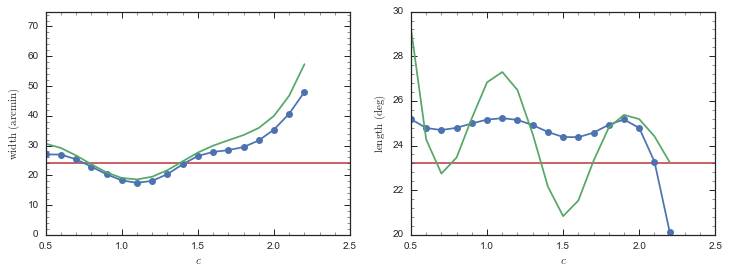

In [31]:
figsize(12,4)
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_constwl[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    overplot=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

It appears that the increase in the stream age undoes the effect of making the stream colder on the width of the stream. This raises the question whether it is at all possible to have a long, cold stream in these $c\neq1$ potentials.

A test with double the number of track points, to see whether that matters. It does not:

In [32]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-ntc16.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=16,nTrackChunks=16,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

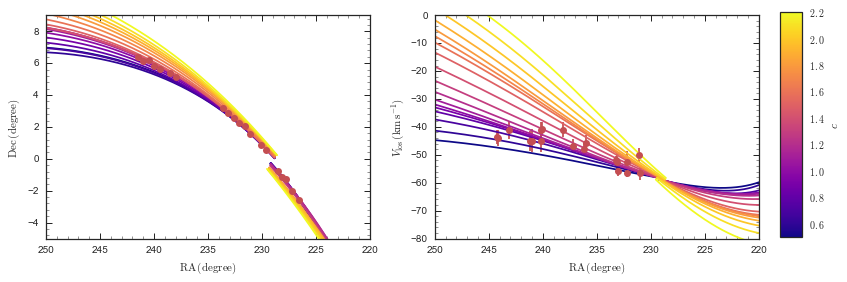

In [33]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

Let's take a look at the grid-points themselves, to see whether the same trend shows for them. They do:

In [34]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-singlec.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.55,1.75,2.,2.25])
    trackRADec_trailing_out= numpy.empty((len(cs),1001,2))
    trackRADec_leading_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_trailing_out= numpy.empty((len(cs),1001,2))
    trackRAVlos_leading_out= numpy.empty((len(cs),1001,2))
    width_out= numpy.empty(len(cs))
    length_out= numpy.empty(len(cs))
    for ii,c in enumerate(cs):
        tpal5varyc= pal5_util.predict_pal5obs(p_b15,c,multi=8,singlec=True)
        trackRADec_trailing_out[ii]= tpal5varyc[0]
        trackRADec_leading_out[ii]= tpal5varyc[1]
        trackRAVlos_trailing_out[ii]= tpal5varyc[2]
        trackRAVlos_leading_out[ii]= tpal5varyc[3]
        width_out[ii]= tpal5varyc[4]
        length_out[ii]= tpal5varyc[5]
    pal5varyc= (trackRADec_trailing_out,trackRADec_leading_out,
                trackRAVlos_trailing_out,trackRAVlos_leading_out,
                width_out,length_out)
    save_pickles(savefilename,cs,pal5varyc)

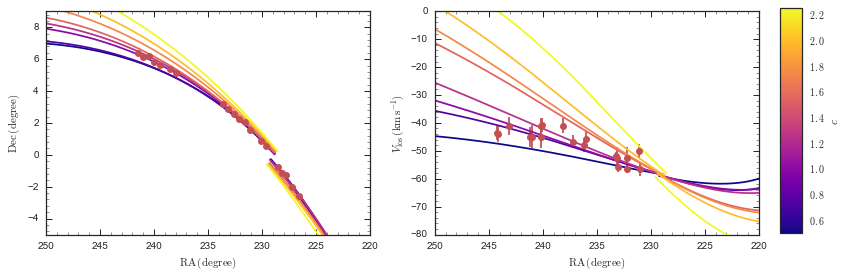

In [35]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

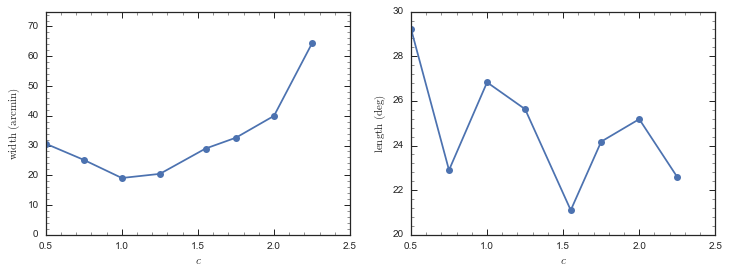

In [36]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

What happens when we use a denser interpolation grid?

In [37]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-densergrid.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.05)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.5,1.6,1.7,1.8,1.9,2.,2.1,2.2])
    save_pickles(savefilename,cs,pal5varyc)

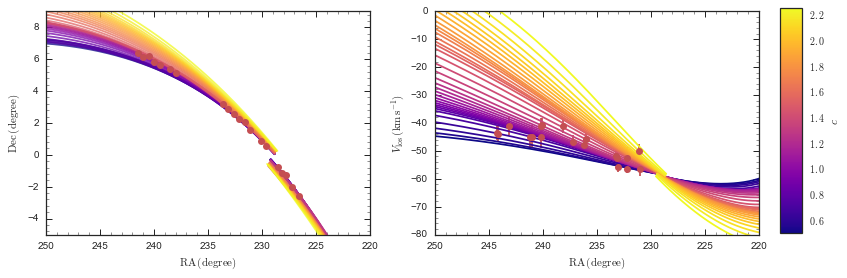

In [38]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True,alpha=0.75)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

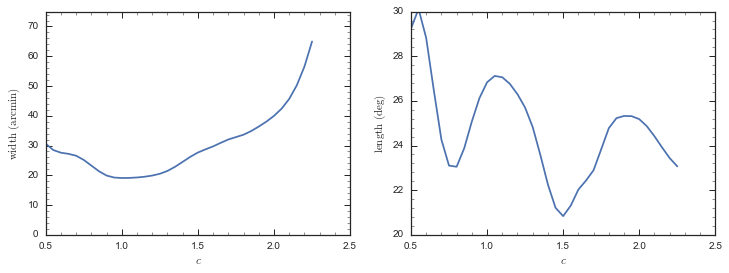

In [39]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)

Does this change for different potential parameters?

In [40]:
p_b15= [0.65,0.3,-1.14,-3.44,1.1,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-shortscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

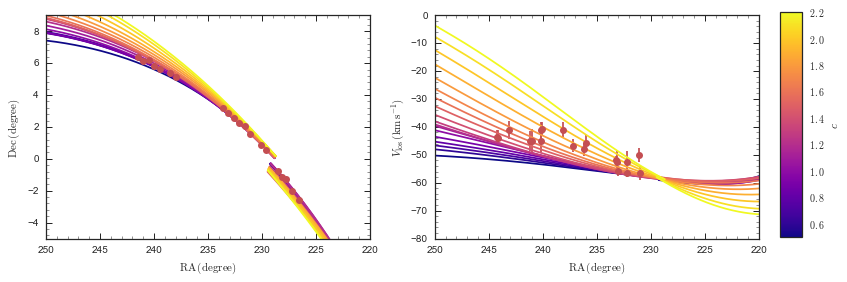

In [41]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < .95 or (c > 1.05 and c < 1.25): continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

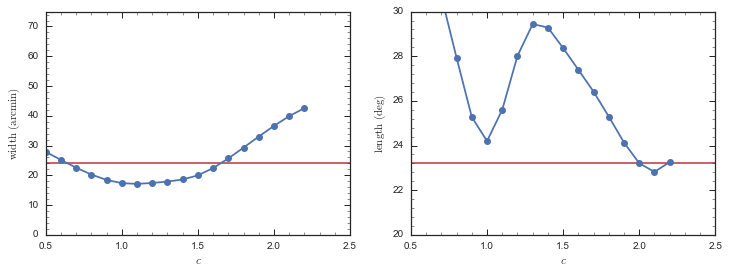

In [42]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another different potential:

In [43]:
p_b15= [0.65,0.3,-0.8,-3.13,0.2,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-longscale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

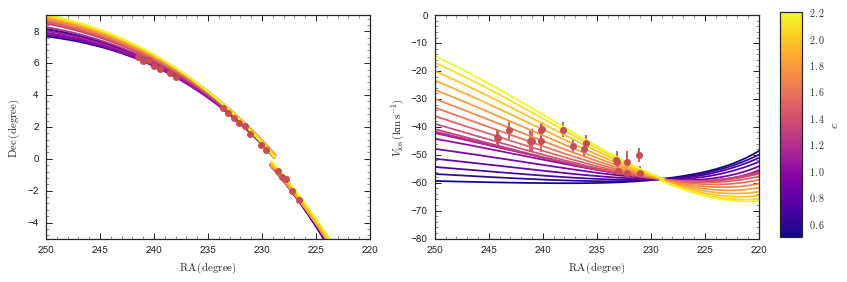

In [44]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if numpy.fabs(c-1.2) > 0.01 and numpy.fabs(c-2.) > 0.01: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

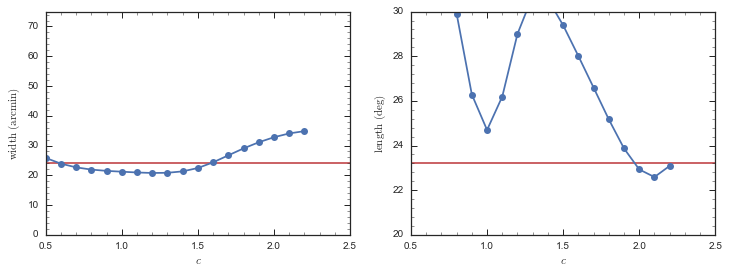

In [45]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

Another one to test:

In [46]:
p_b15= [0.45,0.45,-1.,-3.2,0.9,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-somescale.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.5,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

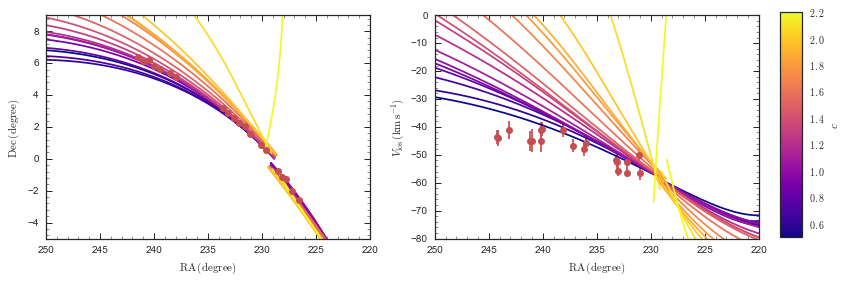

In [47]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

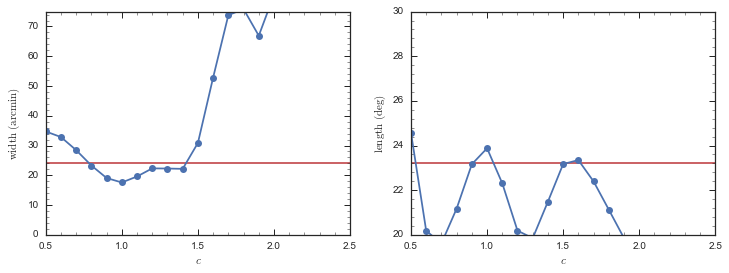

In [48]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## Different distances

In [49]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D22p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.array([0.5,0.75,1.,1.25,1.5,1.75,2.])
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=22.5,interpk=1,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.6,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

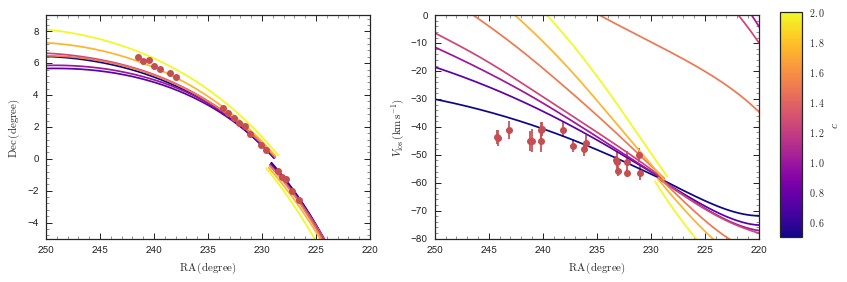

In [50]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c < 1.2 or c > 1.3: continue
#    if c < 2.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

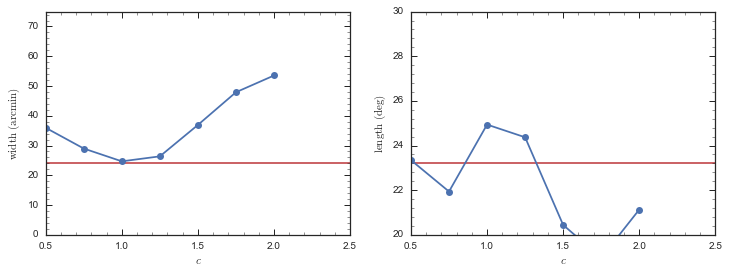

In [51]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

In [52]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-D24p5.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc= pickle.load(savefile)
else:
    cs= numpy.arange(0.8,2.3,0.1)
    pal5varyc= pal5_util.predict_pal5obs(p_b15,cs,multi=8,dist=24.5,useTM=False,
                                         interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25])
    save_pickles(savefilename,cs,pal5varyc)

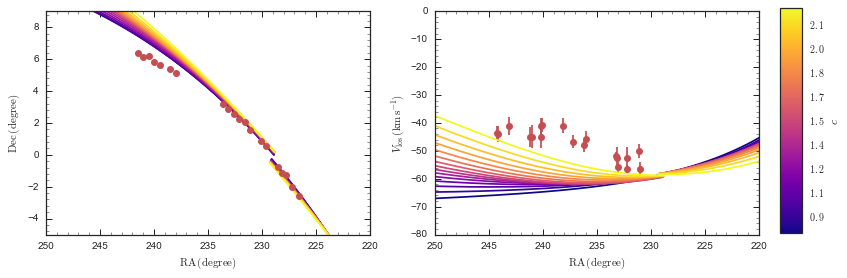

In [53]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
#    if c > 1.: continue
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc[0][ii,:,0],
                        pal5varyc[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[1][ii,:,0],
                        pal5varyc[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc[2][ii,:,0],
                        pal5varyc[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc[3][ii,:,0],
                        pal5varyc[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels()
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

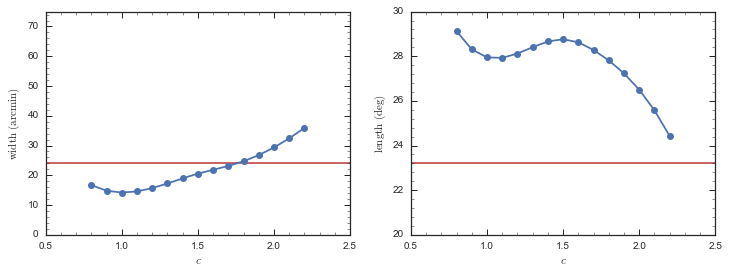

In [54]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc[4],'o-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc[5],'o-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

## A very dens grid of models

In [55]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
savefilename= 'mwpot14-pal5-varyc-like.pkl'
if os.path.exists(savefilename):
    with open(savefilename,'rb') as savefile:
        cs= pickle.load(savefile)
        pal5varyc_like= pickle.load(savefile)
else:
    # First just compute the interpolation points, to adjust the width and length
    interpcs=[0.5,0.75,1.,1.25,1.5,1.75,2.,2.25]
    pal5varyc= pal5_util.predict_pal5obs(p_b15,interpcs,multi=8,interpcs=interpcs)
    cs= numpy.arange(0.5,2.21,0.01)
    sigv=0.4*18./pal5varyc[4]
    td=5.*25./pal5varyc[5]/(sigv/0.4)
    td[td > 14.]= 14. # don't allow older than 14 Gyr
    print sigv
    print td
    pal5varyc_like= pal5_util.predict_pal5obs(p_b15,cs,multi=8,interpcs=pal5varyc[6],
                                              sigv=sigv,td=td)
    save_pickles(savefilename,cs,pal5varyc_like)

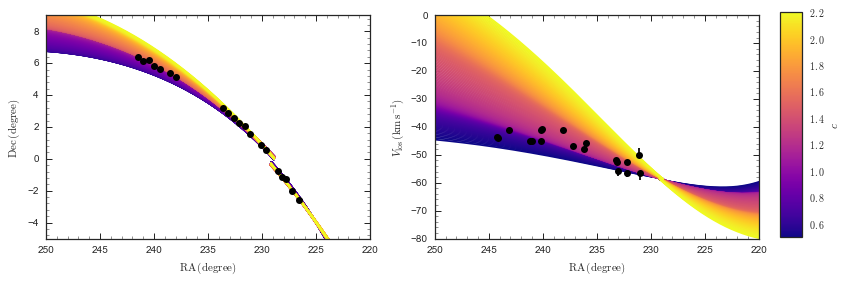

In [56]:
figsize(12,4)
cmap= cm.plasma
for ii, c in enumerate(cs):
    tc= cmap((c-numpy.amin(cs))/(numpy.amax(cs)-numpy.amin(cs)))
    subplot(1,2,1)
    bovy_plot.bovy_plot(pal5varyc_like[0][ii,:,0],
                        pal5varyc_like[0][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[1][ii,:,0],
                        pal5varyc_like[1][ii,:,1],
                        color=tc,overplot=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(pal5varyc_like[2][ii,:,0],
                        pal5varyc_like[2][ii,:,1],
                        color=tc,overplot=True)
    bovy_plot.bovy_plot(pal5varyc_like[3][ii,:,0],
                        pal5varyc_like[3][ii,:,1],
                        color=tc,overplot=True)
plot_data_add_labels(color='k')
add_colorbar(numpy.amin(cs),numpy.amax(cs),r'$c$')

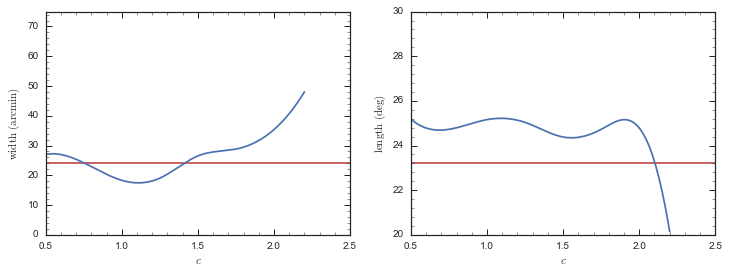

In [57]:
subplot(1,2,1)
bovy_plot.bovy_plot(cs,pal5varyc_like[4],'-',
                    xrange=[0.5,2.5],
                    yrange=[0.,75.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{width}\ (\mathrm{arcmin})$',
                   gcf=True)
pyplot.axhline([24.],color=sns.color_palette()[2],zorder=0)
subplot(1,2,2)
bovy_plot.bovy_plot(cs,pal5varyc_like[5],'-',
                    xrange=[0.5,2.5],
                    yrange=[20.,30.],
                    xlabel=r'$c$',
                    ylabel=r'$\mathrm{length}\ (\mathrm{deg})$',
                   gcf=True)
pyplot.axhline([23.2],color=sns.color_palette()[2],zorder=0)

# MCMC results

## Exploring the likelihood

### Determine the perpendicular proper motion for the fiducial model

In [59]:
reload(pal5_util)

<module 'pal5_util' from 'pal5_util.pyc'>

In [60]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
pmperps= numpy.linspace(-0.005,0.0075,31)
pmlnlike= numpy.zeros(len(pmperps))
for ii,pmp in enumerate(pmperps):
    prog= Orbit([229.018,-0.124,23.2,-2.296+pmp,-2.257-pmp/2.257*2.296,-58.7],
                radec=True,ro=ro,vo=vo,
                solarmotion=[-11.1,24.,7.25])
    tsdf_trailing= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True,
                                      verbose=False)
    trackRADec_trailing= bovy_coords.lb_to_radec(\
        tsdf_trailing._interpolatedObsTrackLB[:,0],
        tsdf_trailing._interpolatedObsTrackLB[:,1],
        degree=True)
    trackRADec_trailing= numpy.reshape(trackRADec_trailing,(1,trackRADec_trailing.shape[0],
                                                            trackRADec_trailing.shape[1]))
    pmlnlike[ii]= pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                        trackRADec_trailing,trackRADec_trailing,
                                        trackRADec_trailing,trackRADec_trailing,
                                        numpy.array([0.]),numpy.array([0.]),None)[0,0]

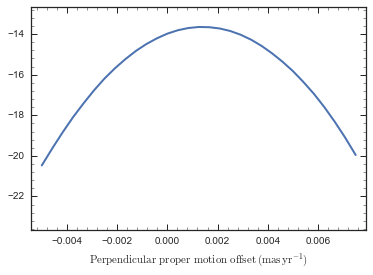

In [61]:
figsize(6,4)
bovy_plot.bovy_plot(pmperps, pmlnlike,'-',lw=2.,
                    xlabel=r'$\mathrm{Perpendicular\ proper\ motion\ offset}\,(\mathrm{mas\,yr}^{-1})$',
                    xrange=[pmperps[0]-(pmperps[1]-pmperps[0]),pmperps[-1]+(pmperps[1]-pmperps[0])],
                    yrange=[-10.+numpy.amax(pmlnlike),1.+numpy.amax(pmlnlike)])

Because it's so close to zero and the likelihood isn't too different, we'll just keep the FK15 proper motion.

### Determine stream-orbit offset for fiducial model

In [232]:
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
sdf_trailing= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True)

(1.0, 0.67406308777997392)


Which is a good point near the beginning of the trailing stream?

In [233]:
# RA, Dec of the trailing stream in the fiducial model
trackRADec_trailing= bovy_coords.lb_to_radec(\
    sdf_trailing._interpolatedObsTrackLB[:,0],
    sdf_trailing._interpolatedObsTrackLB[:,1],
    degree=True)
trackpmRADec_trailing= bovy_coords.pmllpmbb_to_pmrapmdec(\
    sdf_trailing._interpolatedObsTrackLB[:,4],
    sdf_trailing._interpolatedObsTrackLB[:,5],
    sdf_trailing._interpolatedObsTrackLB[:,0],
    sdf_trailing._interpolatedObsTrackLB[:,1],
    degree=True)
# Interpolate...
sindx= numpy.argsort(trackRADec_trailing[:,0])
ipdec= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[sindx,0],
                                                trackRADec_trailing[sindx,1])
ipdist= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[sindx,0],
                                                 sdf_trailing._interpolatedObsTrackLB[sindx,2])
ippmra= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[sindx,0],
                                                 trackpmRADec_trailing[sindx,0])
ippmdec= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[sindx,0],
                                                 trackpmRADec_trailing[sindx,1])
ipvlos= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[sindx,0],
                                                 sdf_trailing._interpolatedObsTrackLB[sindx,3])

tpos_radec= pos_radec[pos_radec[:,0] > 229.]
good_ra= tpos_radec[numpy.argmin(numpy.fabs(tpos_radec[:,0]-229.)),0]
print "Starting point of the trailing stream:"
print good_ra, ipdec(good_ra), ipdist(good_ra), ippmra(good_ra), ippmdec(good_ra), ipvlos(good_ra)
print "Offset between starting point and the progenitor:"
print good_ra, ipdec(good_ra)-prog.dec()[0], ipdist(good_ra)-prog.dist()[0], \
    ippmra(good_ra)-prog.pmra()[0], ippmdec(good_ra)-prog.pmdec()[0], ipvlos(good_ra)-prog.vlos()[0], \
    ((ippmra(good_ra)-prog.pmra()[0])*2.296+(ippmdec(good_ra)-prog.pmdec()[0])*2.257)/(2.296**2.+2.257**2.)**0.5

Starting point of the trailing stream:
229.11 0.311591562249 23.4959565923 -2.27232104008 -2.21917175787 -58.516540586
Offset between starting point and the progenitor:
229.11 0.435591562249 0.295956592287 0.0236789599151 0.0378282421314 0.183459413995 0.0434048662298


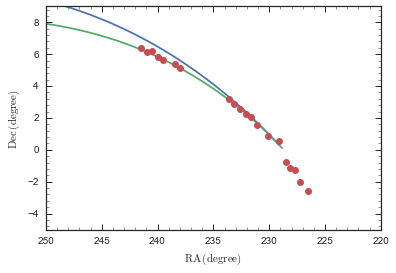

In [235]:
figsize(6,4)
progt= Orbit([229.11,0.3,23.5,-2.27,-2.22,-58.5],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25]).flip()
ts= numpy.linspace(0.,3.,1001)
progt.integrate(ts,pot)
progt.plot(d1='ra',d2='dec')
plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
xlim(250.,220.)
ylim(-5.,9.)
plot_data_add_labels(radeconly=True)

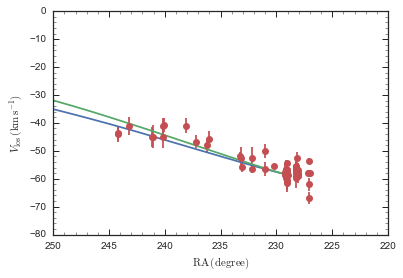

In [240]:
progt= Orbit([229.11,0.3,23.5,-2.27,-2.22,-58.5],radec=True,ro=ro,vo=vo,
             solarmotion=[-11.1,24.,7.25]).flip()
ts= numpy.linspace(0.,3.,1001)
progt.integrate(ts,pot)
progt._orb.orbit[:,1]*= -1.
progt._orb.orbit[:,2]*= -1.
progt._orb.orbit[:,4]*= -1.
progt.plot(d1='ra',d2='vlos')
plot(trackRADec_trailing[:,0],sdf_trailing._interpolatedObsTrackLB[:,3])
xlim(250.,220.)
ylim(-80.,0.)
plot_data_add_labels(rvonly=True)

Stream-orbit offset for different $c$:

In [241]:
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.15,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
sdf_trailing_hc= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True,isob=0.8)
pot= MWPotential2014Likelihood.setup_potential(p_b15,0.75,False,False,ro,vo)
prog= Orbit([229.018,-0.124,23.2,-2.296,-2.257,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
sdf_trailing_cc= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True,isob=0.8)

(1.15, 0.8)
(0.75, 0.8)


Are the stream-orbit offsets similar?

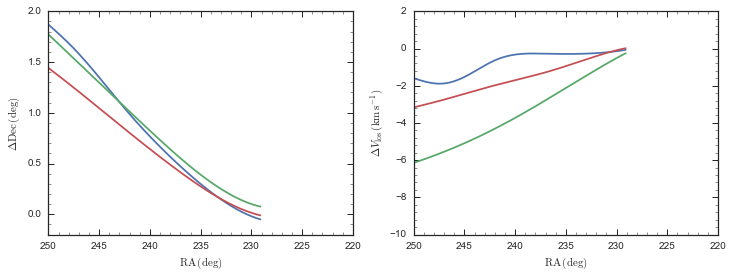

In [244]:
figsize(12,4)
overplot=False
for c,sdf in zip([1.25,0.75,1.],[sdf_trailing_hc,sdf_trailing_cc,sdf_trailing]):
    pot= MWPotential2014Likelihood.setup_potential(p_b15,c,False,False,ro,vo)
    progt= Orbit([229.11,0.3,23.5,-2.27,-2.22,-58.5],radec=True,ro=ro,vo=vo,
                 solarmotion=[-11.1,24.,7.25]).flip()
    ts= numpy.linspace(0.,3.,1001)
    progt.integrate(ts,pot)
    progt._orb.orbit[:,1]*= -1.
    progt._orb.orbit[:,2]*= -1.
    progt._orb.orbit[:,4]*= -1.
    oras, odecs, ovloss= progt.ra(ts), progt.dec(ts), progt.vlos(ts)
    trackRADec_trailing= bovy_coords.lb_to_radec(\
        sdf._interpolatedObsTrackLB[:,0],
        sdf._interpolatedObsTrackLB[:,1],
        degree=True)
    # Interpolate onto common RA
    ipdec= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[:,0],
                                                    trackRADec_trailing[:,1])
    ipvlos= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[:,0],
                                                    sdf._interpolatedObsTrackLB[:,3])
    #plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
    #continue
    subplot(1,2,1)
    bovy_plot.bovy_plot(oras,odecs-ipdec(oras),
                        xrange=[250.,220.],
                        yrange=[-0.2,2.],
                        xlabel=r'$\mathrm{RA}\,(\mathrm{deg})$',
                        ylabel=r'$\Delta\mathrm{Dec}\,(\mathrm{deg})$',
                        overplot=overplot,gcf=True)
    subplot(1,2,2)
    bovy_plot.bovy_plot(oras,ovloss-ipvlos(oras),
                        xrange=[250.,220.],
                        yrange=[-10.,2.],
                        xlabel=r'$\mathrm{RA}\,(\mathrm{deg})$',
                        ylabel=r'$\Delta V_\mathrm{los}\,(\mathrm{km\,s}^{-1})$',
                        overplot=overplot,gcf=True)
    overplot= True

In [245]:
save_pickles('pal5_stream_orbit_offset.pkl',oras,odecs-ipdec(oras),ovloss-ipvlos(oras))

That's pretty similar!

In [530]:
def stream_orb_offset(sdf,pot,dist,pmoff,ro=_REFR0,vo=_REFV0):
    """Function to calculate the offset between a stream track and an approximate orbit"""
    progt= Orbit([229.11,0.3,dist,-2.27+pmoff,-2.22+2.257/2.296*pmoff,-58.5],
                 radec=True,ro=ro,vo=vo,
                 solarmotion=[-11.1,24.,7.25]).flip()
    ts= numpy.linspace(0.,3.,1001)
    progt.integrate(ts,pot)
    progt._orb.orbit[:,1]*= -1.
    progt._orb.orbit[:,2]*= -1.
    progt._orb.orbit[:,4]*= -1.
    oras, odecs, ovloss= progt.ra(ts), progt.dec(ts), progt.vlos(ts)
    trackRADec_trailing= bovy_coords.lb_to_radec(\
        sdf._interpolatedObsTrackLB[:,0],
        sdf._interpolatedObsTrackLB[:,1],
        degree=True)
    # Interpolate onto common RA
    ipdec= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[:,0],
                                                    trackRADec_trailing[:,1])
    ipvlos= interpolate.InterpolatedUnivariateSpline(trackRADec_trailing[:,0],
                                                    sdf._interpolatedObsTrackLB[:,3])
    return (oras,odecs-ipdec(oras),ovloss-ipvlos(oras))

### Find good (distance,proper motion) for a given potential

In [62]:
reload(pal5_util)
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
test= pal5_util.pal5_dpmguess(pot,
                   dmin=22.8,dmax=24.8,dstep=0.025,
                   pmmin=-0.1,pmmax=0.2,pmstep=0.001)

Determining good distance and parallel proper motion...


/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':

/Users/bovy/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):



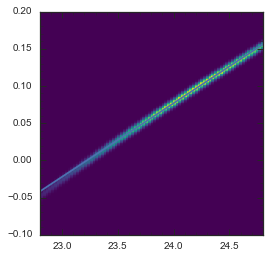

In [63]:
bovy_plot.bovy_dens2d(numpy.exp(test[2]-numpy.nanmax(test[2])).T,origin='lower',
                      cmap='viridis',interpolation='nearest',
                      xrange=[numpy.amin(test[3]),numpy.amax(test[3])],
                      yrange=[numpy.amin(test[4]),numpy.amax(test[4])])
ds= numpy.linspace(22.5,25.,1001)
plot(ds,(ds-24.)*0.099+0.0769)

What is the line of the best fit?

In [64]:
md= numpy.sum(numpy.exp(test[2])*numpy.tile(test[3],(len(test[4]),1)).T)/numpy.sum(numpy.exp(test[2]))
mpm= numpy.sum(numpy.exp(test[2])*numpy.tile(test[4],(len(test[3]),1)))/numpy.sum(numpy.exp(test[2]))
print md, mpm
dstd= numpy.sqrt(numpy.sum(numpy.exp(test[2])*numpy.tile((test[3]-md)**2.,(len(test[4]),1)).T)/numpy.sum(numpy.exp(test[2])))
pmstd= numpy.sqrt(numpy.sum(numpy.exp(test[2])*numpy.tile((test[4]-mpm)**2.,(len(test[3]),1)))/numpy.sum(numpy.exp(test[2])))
corr= numpy.sum(numpy.exp(test[2])*numpy.tile(test[3]-md,(len(test[4]),1)).T\
                *numpy.tile(test[4]-mpm,(len(test[3]),1)))/numpy.sum(numpy.exp(test[2]))/dstd/pmstd
print dstd, pmstd, corr, corr*pmstd/dstd

24.0135086597 0.078007754254
0.47842745098 0.0474955351177 0.997071261838 0.0989835199349


Setup the best model according to this procedure:

In [67]:
bestd= test[3][numpy.unravel_index(numpy.argmax(test[2]),test[2].shape)[0]]
bestpmoff= test[4][numpy.unravel_index(numpy.argmax(test[2]),test[2].shape)[1]]
print bestd, bestpmoff

24.2 0.097


In [69]:
bestd= test[3][numpy.unravel_index(numpy.argmax(test[2]),test[2].shape)[0]]
bestpmoff= test[4][numpy.unravel_index(numpy.argmax(test[2]),test[2].shape)[1]]
print bestd, bestpmoff
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
prog= Orbit([229.018,-0.124,bestd,-2.296+bestpmoff,-2.257+bestpmoff*2.257/2.296,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
sdf_trailing_test= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True)

24.2 0.097
(1.0, 0.71215407735472214)


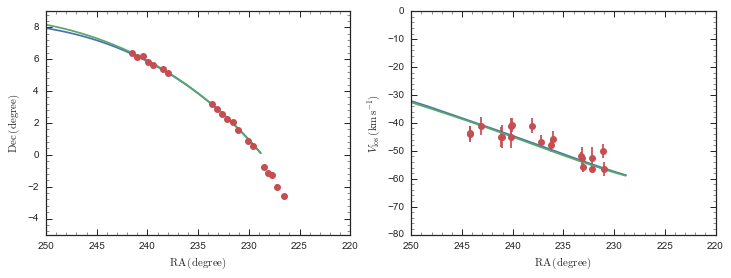

In [70]:
figsize(12,4)
subplot(1,2,1)
trackRADec_trailing= bovy_coords.lb_to_radec(\
    sdf_trailing._interpolatedObsTrackLB[:,0],
    sdf_trailing._interpolatedObsTrackLB[:,1],
    degree=True)
plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
subplot(1,2,2)
plot(trackRADec_trailing[:,0],
                    sdf_trailing._interpolatedObsTrackLB[:,3])
subplot(1,2,1)
trackRADec_trailing= bovy_coords.lb_to_radec(\
    sdf_trailing_test._interpolatedObsTrackLB[:,0],
    sdf_trailing_test._interpolatedObsTrackLB[:,1],
    degree=True)
plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
subplot(1,2,2)
plot(trackRADec_trailing[:,0],
                    sdf_trailing_test._interpolatedObsTrackLB[:,3])
plot_data_add_labels(radeconly=False)

Now we test finding a good fit going along the distance-proper-motion covariance:

In [447]:
reload(pal5_util)
p_b15= [0.60122692,0.36273147,-0.97591502,-3.34169377,
        0.71877924,-0.01519337,-0.01928001]
pot= MWPotential2014Likelihood.setup_potential(p_b15,1.,False,False,ro,vo)
testalong= pal5_util.pal5_dpmguess(\
    pot,dmin=22.8,dmax=24.8,dstep=0.025,
    pmmin=-0.005,pmmax=0.005,pmstep=0.001,alongbfpm=True)

Determining good distance and parallel proper motion...


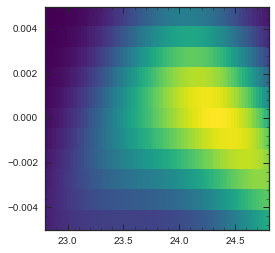

In [448]:
bovy_plot.bovy_dens2d(numpy.exp(testalong[2]-numpy.nanmax(testalong[2])).T,origin='lower',
                      cmap='viridis',interpolation='nearest',
                      xrange=[numpy.amin(testalong[3]),numpy.amax(testalong[3])],
                      yrange=[numpy.amin(testalong[4]),numpy.amax(testalong[4])])

## Likelihoods with the new approach

In [5]:
def plot_combined_c(*args,**kwargs):
    """args= set of filenames"""
    tvo= float(args[0].split('vo')[1].split('_')[0])
    # Read first one for c grid
    with open(args[0],'rb') as savefile:
        line1= savefile.readline()
        cline= savefile.readline()
        dline= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    cmin= float(re.split(' |,',cline)[4])
    cmax= float(re.split(' |,',cline)[5])
    cstep= float(re.split(' |,',cline)[6])
    cs= numpy.arange(cmin,cmax+cstep/2.,cstep)
    out= numpy.empty((len(cs),len(args)))
    allout= []
    for ii,fname in enumerate(args):
        tout= numpy.loadtxt(fname,delimiter=',',comments='#')
        tout[numpy.isnan(tout)]= -10000000000000.
        tout= numpy.reshape(tout,(tout.shape[0]//5,5,tout.shape[1]))
        allout.append(numpy.sum(tout[:,:3],axis=1))
        out[:,ii] = logsumexp(numpy.sum(tout[:,:3],axis=1),axis=0)
    if len(args) == 1: mout= numpy.amax(numpy.array(allout))
    else: mout= numpy.nan
    if kwargs.pop('eqw',False):
        for ii in range(out.shape[-1]):
            out[:,ii]-= logsumexp(out[:,ii])
    if kwargs.pop('eqmax',False):
        for ii in range(out.shape[-1]):
            out[:,ii]-= numpy.nanmax(out[:,ii])
    if kwargs.get('ar',False) or kwargs.get('az',False):
        fs= numpy.zeros((len(cs),3,len(args)))
        for ii,fname in enumerate(args):
            with open(fname,'rb') as savefile:
                line1= savefile.readline()
            potparams= [float(s) for s in (line1.split(':')[1].split(','))]
            for jj,c in enumerate(cs):
                pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
                # for D=23.46, R=~ 8.4 kpc, Z=~ 16.8 kpc to within 8 pc
                fs[jj,:,ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
        if len(args) == 0:
            if kwargs.pop('ar',False):
                xs= fs[:,0]
            if kwargs.pop('az',False):
                xs= fs[:,1]
            jac= numpy.fabs((cs[1]-cs[0])/(numpy.roll(xs,-1)-xs))
            out+= numpy.log(jac)
            cs= xs
        else:
            # Need to interpolate onto a common grid
            if kwargs.get('ar',False):
                cxs= numpy.linspace(-1.5,-0.5,len(cs))
            if kwargs.get('az',False):
                cxs= numpy.linspace(-2.3,-1.4,len(cs))
            for ii in range(len(args)):
                if kwargs.get('ar',False):
                    xs= fs[:,0,ii]
                if kwargs.get('az',False):
                    xs= fs[:,1,ii]
                jac= numpy.fabs((cs[1]-cs[0])/(numpy.roll(xs,-1)-xs))
                out[:,ii]+= numpy.log(jac)
                sindx= numpy.argsort(xs)
                sindx2= sindx*(True-numpy.isnan(out[sindx,ii]))
                ip= interpolate.InterpolatedUnivariateSpline(xs[sindx2],out[sindx2,ii],k=1,ext=3)
                out[:,ii]= ip(cxs)
            kwargs.pop('ar',None)
            kwargs.pop('az',None)
            cs= cxs
    out= logsumexp(out,axis=-1).T
    # Plot
    totlnlike= logsumexp(out)
    comb= numpy.exp(out-numpy.amax(out))
    kwargs['xrange']= kwargs.get('xrange',[numpy.amin(cs),numpy.amax(cs)])
    bovy_plot.bovy_plot(cs,comb,lw=2.,
                       xlabel=r'$c$',
                       yrange=[0.,1.4],
                       **kwargs)
    m= numpy.sum(cs*comb)/numpy.sum(comb)
    pot= MWPotential2014Likelihood.setup_potential(potparams,m,False,False,ro,vo)
    if kwargs.get('overplot',False): return (cs[numpy.argmax(comb)],m,totlnlike)
    m= numpy.sum(cs*comb)/numpy.sum(comb)
    pot= MWPotential2014Likelihood.setup_potential(potparams,m,False,False,ro,vo)
    bovy_plot.bovy_text(r'$\mathrm{max} = %f$' % mout
                        +'\n'+r'$\vec{a} = (%.3f,%.3f,%.3f)$' % MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)
                        +'\n'+r'$|\vec{a}| = %.3f$' % numpy.sqrt(numpy.sum(numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))**2.))
,
                        top_left=True)
    bovy_plot.bovy_text(r'$\mathrm{mode} = %.2f$' % cs[numpy.argmax(comb)]
                        +'\n\n\n'+r'$\mathrm{mean} = %.3f$' % m
                        +'\n'+r'$\sigma = %.3f$' % numpy.sqrt(numpy.sum((cs-m)**2.*comb)/numpy.sum(comb)),
                        top_right=True)
    #print "Mode, mean, std.dev., P(c<1):" ,\
    #    cs[numpy.argmax(comb)], m, numpy.sqrt(numpy.sum((cs-m)**2.*comb)/numpy.sum(comb)), \
    #    numpy.cumsum(comb/numpy.sum(comb))[numpy.fabs(cs-1.) < 0.005][0]
    return (cs[numpy.argmax(comb)],m,totlnlike)
def plot_combined_d(*args,**kwargs):
    """args= set of filenames"""
    # Read first one for c and d grid
    with open(args[0],'rb') as savefile:
        line1= savefile.readline()
        cline= savefile.readline()
        dline= savefile.readline()
    dmin= float(re.split(' |,',dline)[4])
    dmax= float(re.split(' |,',dline)[5])
    dstep= float(re.split(' |,',dline)[6])
    ds= numpy.arange(dmin,dmax+dstep,dstep)
    if ds[-1] > dmax+dstep/2.: ds= ds[:-1]
    cmin= float(re.split(' |,',cline)[4])
    cmax= float(re.split(' |,',cline)[5])
    cstep= float(re.split(' |,',cline)[6])
    cs= numpy.arange(cmin,cmax+cstep/2.,cstep)
    out= numpy.empty((len(ds)*7,len(args)))
    for ii,fname in enumerate(args):
        tout= numpy.loadtxt(fname,delimiter=',',comments='#')
        tout[numpy.isnan(tout)]= -10000000000000.
        tout= numpy.reshape(tout,(tout.shape[0]//5,5,tout.shape[1]))
        tmp_out= logsumexp(numpy.sum(tout[:,:3],axis=1),axis=-1)
        out[:tmp_out.shape[0],ii] = tmp_out
    out= out[:tmp_out.shape[0]]
    npm= kwargs.pop('npm',7)
    if kwargs.pop('margpm',False):
        out= out[:7*(out.shape[0]//7)]
        out= numpy.reshape(out,(out.shape[0]//7,7,out.shape[1]))
        out= logsumexp(out,axis=1)
    out= logsumexp(out,axis=1).T
    ds= ds[:out.shape[0]]
    # Plot
    comb= numpy.exp(out-numpy.amax(out))*(numpy.random.uniform()/5.+0.9)
    bovy_plot.bovy_plot(ds,comb,lw=2.,
                       xlabel=r'$\mathrm{distance}\,(\mathrm{kpc})$',
                       xrange=[dmin-dstep,dmax+dstep],
                       yrange=[0.,1.2],
                       **kwargs)
    m= numpy.sum(ds*comb)/numpy.sum(comb)
    print "Mode, mean, std.dev.):" ,\
        ds[numpy.argmax(comb)], m, numpy.sqrt(numpy.sum((ds-m)**2.*comb)/numpy.sum(comb))
def plot_combined_cd(*args,**kwargs):
    """args= set of filenames"""
    # Read first one for c grid
    with open(args[0],'rb') as savefile:
        line1= savefile.readline()
        cline= savefile.readline()
        dline= savefile.readline()
    dmin= float(re.split(' |,',dline)[4])
    dmax= float(re.split(' |,',dline)[5])
    dstep= float(re.split(' |,',dline)[6])
    ds= numpy.arange(dmin,dmax+dstep,dstep)
    cmin= float(re.split(' |,',cline)[4])
    cmax= float(re.split(' |,',cline)[5])
    cstep= float(re.split(' |,',cline)[6])
    cs= numpy.arange(cmin,cmax+cstep/2.,cstep)
    out= numpy.empty((len(ds)*7,len(cs),len(args)))
    for ii,fname in enumerate(args):
        tout= numpy.loadtxt(fname,delimiter=',',comments='#')
        tout[numpy.isnan(tout)]= -10000000000000.
        tout= numpy.reshape(tout,(tout.shape[0]//5,5,tout.shape[1]))
        tmp_out= numpy.sum(tout[:,:3],axis=1)
        out[:tmp_out.shape[0],:,ii] = tmp_out
    out= out[:tmp_out.shape[0]]
    mout= numpy.amax(out)
    npm= kwargs.pop('npm',7)
    if kwargs.pop('margpm',False):
        out= out[:7*(out.shape[0]//7)]
        out= numpy.reshape(out,(out.shape[0]//7,7,out.shape[1],out.shape[2]))
        out= logsumexp(out,axis=1)
    if kwargs.pop('margd',False):
        out= out[:7*(out.shape[0]//7)]
        out= numpy.reshape(out,(out.shape[0]//7,7,out.shape[1],out.shape[2]))
        out= logsumexp(out,axis=0)
    out= logsumexp(out,axis=-1).T
    # Plot
    xrange= kwargs.pop('xrange',[0.9,1.2])
    cilow= int(numpy.floor(numpy.argmin(numpy.fabs(cs-xrange[0]))))
    cihigh= int(numpy.ceil(numpy.argmin(numpy.fabs(cs-xrange[1]))))
    cs= cs[cilow:cihigh]
    out= out[cilow:cihigh]
    ds= ds[:out.shape[1]]
    comb= numpy.exp(out-numpy.amax(out))
    bovy_plot.bovy_dens2d(comb.T,origin='lower',cmap='viridis',
                          xlabel=r'$c$',
                          ylabel=r'$\mathrm{distance}\,(\mathrm{kpc})$',
                          xrange=[numpy.amin(cs)-cstep,numpy.amax(cs)+cstep],
                          yrange=[numpy.amin(ds)-dstep,numpy.amax(ds)+dstep],
                          contours=False,
                         **kwargs)
    bovy_plot.bovy_text(r'$\mathrm{max} = %f$' % mout,top_left=True,color='w')
def plot_combined_pmd(*args,**kwargs):
    """args= set of filenames"""
    # Read first one for c grid
    with open(args[0],'rb') as savefile:
        line1= savefile.readline()
        cline= savefile.readline()
        dline= savefile.readline()
    dmin= float(re.split(' |,',dline)[4])
    dmax= float(re.split(' |,',dline)[5])
    dstep= float(re.split(' |,',dline)[6])
    ds= numpy.arange(dmin,dmax+dstep,dstep)
    cmin= float(re.split(' |,',cline)[4])
    cmax= float(re.split(' |,',cline)[5])
    cstep= float(re.split(' |,',cline)[6])
    cs= numpy.arange(cmin,cmax+cstep/2.,cstep)
    out= numpy.empty((len(ds)*7,len(cs),len(args)))
    for ii,fname in enumerate(args):
        tout= numpy.loadtxt(fname,delimiter=',',comments='#')
        tout[numpy.isnan(tout)]= -10000000000000.
        tout= numpy.reshape(tout,(tout.shape[0]//5,5,tout.shape[1]))
        tmp_out= numpy.sum(tout[:,:3],axis=1)
        out[:tmp_out.shape[0],:,ii] = tmp_out
    out= out[:tmp_out.shape[0]]
    npm= kwargs.pop('npm',7)
    out= out[:npm*(out.shape[0]//npm)]
    out= numpy.reshape(out,(out.shape[0]//npm,npm,out.shape[1],out.shape[2]))
    out= logsumexp(out,axis=2)
    out= logsumexp(out,axis=-1)
    # Plot
    ds= ds[:out.shape[1]]
    comb= numpy.exp(out-numpy.amax(out))
    bovy_plot.bovy_dens2d(comb.T,origin='lower',cmap='viridis',
                          ylabel=r'$\Delta mu\,(\mathrm{mas\,yr}^{-1})$',
                          xlabel=r'$\mathrm{distance}\,(\mathrm{kpc})$',
                          yrange=[0,npm],
                          xrange=[numpy.amin(ds)-dstep,numpy.amax(ds)+dstep],
                          contours=False,
                         **kwargs)

## Results as constraints on $(F_R,F_z)$ at Pal 5

What is the 'prior' coming from the disk constraints? For $V_c(R_0) = 220$ km/s:

In [457]:
samples_savefilename= 'mwpot14varyc-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    raise IOError('File %s with the samples does not exist' % samples_savefilename)
nsamp= 10000
numpy.random.seed(1)
rndindx= numpy.random.permutation(s.shape[1])
pot_params= s[:,rndindx][:,:nsamp]
fs= numpy.zeros((nsamp,2))
tvo= 220.
for ii,p in enumerate(pot_params.T):
    c= numpy.random.uniform()*1.5+0.5
    pot= MWPotential2014Likelihood.setup_potential(p,c,False,False,ro,tvo)
    fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))[:2]

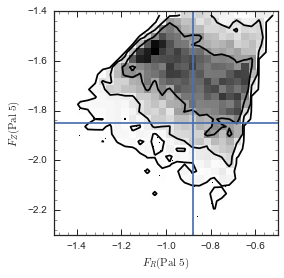

In [458]:
bovy_plot.scatterplot(fs[:,0],fs[:,1],'k,',
                      xrange=[-1.5,-0.5],
                      yrange=[-2.3,-1.4],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                     ylabel=r'$F_Z(\mathrm{Pal\ 5})$',)
pyplot.axvline(-0.88*(tvo/220.),color=sns.color_palette()[0])
pyplot.axhline(-1.85*(tvo/220.)**2.,color=sns.color_palette()[0])

For $V_c(R_0) = 230$ km/s:

In [459]:
samples_savefilename= 'mwpot14varyc-samples.pkl'
if os.path.exists(samples_savefilename):
    with open(samples_savefilename,'rb') as savefile:
        s= pickle.load(savefile)
else:
    raise IOError('File %s with the samples does not exist' % samples_savefilename)
nsamp= 10000
numpy.random.seed(1)
rndindx= numpy.random.permutation(s.shape[1])
pot_params= s[:,rndindx][:,:nsamp]
fs= numpy.zeros((nsamp,2))
tvo= 230.
for ii,p in enumerate(pot_params.T):
    c= numpy.random.uniform()*1.5+0.5
    pot= MWPotential2014Likelihood.setup_potential(p,c,False,False,ro,tvo)
    fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))[:2]

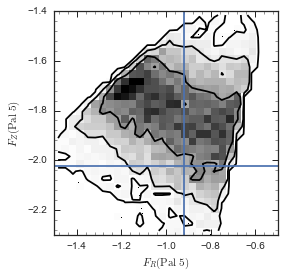

In [460]:
bovy_plot.scatterplot(fs[:,0],fs[:,1],'k,',
                      xrange=[-1.5,-0.5],
                      yrange=[-2.3,-1.4],
                      xlabel=r'$F_R(\mathrm{Pal\ 5})$',
                     ylabel=r'$F_Z(\mathrm{Pal\ 5})$',)
pyplot.axvline(-0.88*(tvo/220.),color=sns.color_palette()[0])
pyplot.axhline(-1.85*(tvo/220.)**2.,color=sns.color_palette()[0])

(-2.0, -1.0)

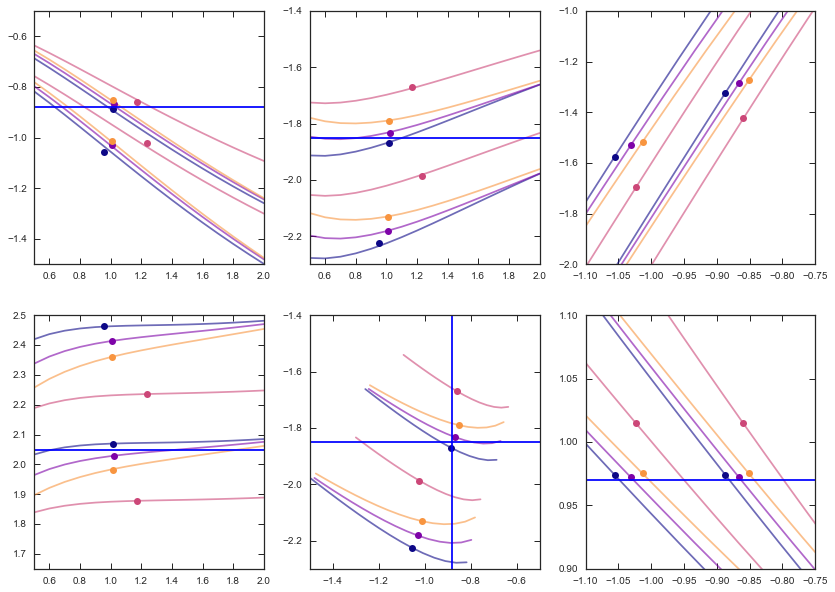

In [16]:
figsize(14,10)
cs= numpy.linspace(0.5,2.,16)
tvo= 240.
fns= ['pot%i_vo230_ro8_newd.dat' % ii for ii in range(20)]
cmap= cm.plasma
means.extend([-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000])
totnum= 4
for jj in range(totnum):
    with open(fns[jj],'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    fs= numpy.zeros((len(cs),3))
    for ii,c in enumerate(cs):
        pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
        fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
    cindx= numpy.argmin(numpy.fabs(cs-means3[jj]))
    subplot(2,3,1)
    plot(cs,fs[:,0],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],fs[cindx,0],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,2)
    plot(cs,fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,4)
    plot(cs,numpy.sqrt(numpy.sum(fs**2.,axis=1)),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],numpy.sqrt(numpy.sum(fs**2.,axis=1))[cindx],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,5)
    plot(fs[:,0],fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,6)
    plot(fs[:,0],numpy.sqrt(2.*fs[:,0]/fs[:,1]),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],numpy.sqrt(2.*fs[cindx,0]/fs[cindx,1]),color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,3)
    plot(fs[:,0],3.6*fs[:,0]-fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],3.6*fs[cindx,0]-fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    
tvo= 220.
fns= ['pot%i_vo220_ro8_newd.dat' % ii for ii in range(20)]
totnum=4
for jj in range(totnum):
    with open(fns[jj],'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    fs= numpy.zeros((len(cs),3))
    for ii,c in enumerate(cs):
        pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
        fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
    cindx= numpy.argmin(numpy.fabs(cs-means[jj]))
    subplot(2,3,1)
    plot(cs,fs[:,0],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,0],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,2)
    plot(cs,fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,4)
    plot(cs,numpy.sqrt(numpy.sum(fs**2.,axis=1)),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],numpy.sqrt(numpy.sum(fs**2.,axis=1))[cindx],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,5)
    plot(fs[:,0],fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,6)
    plot(fs[:,0],numpy.sqrt(2.*fs[:,0]/fs[:,1]),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],numpy.sqrt(2.*fs[cindx,0]/fs[cindx,1]),color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,3)
    plot(fs[:,0],3.6*fs[:,0]-fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],3.6*fs[cindx,0]-fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    
subplot(2,3,1)
pyplot.axhline(-0.88)
xlim(0.5,2.)
ylim(-1.5,-0.5)
subplot(2,3,2)
pyplot.axhline(-1.85)
xlim(0.5,2.)
ylim(-2.3,-1.4)
subplot(2,3,4)
pyplot.axhline(numpy.sqrt((-1.85)**2.+(-0.88)**2.))
xlim(0.5,2.)
ylim(1.65,2.5)
subplot(2,3,5)
pyplot.axvline(-0.88)
pyplot.axhline(-1.85)
xlim(-1.5,-0.5)
ylim(-2.3,-1.4)
subplot(2,3,6)
pyplot.axhline(0.97)
xlim(-1.1,-0.75)
ylim(0.9,1.1)
subplot(2,3,3)
xlim(-1.1,-0.75)
ylim(-2.,-1.)

(-2.0, -1.0)

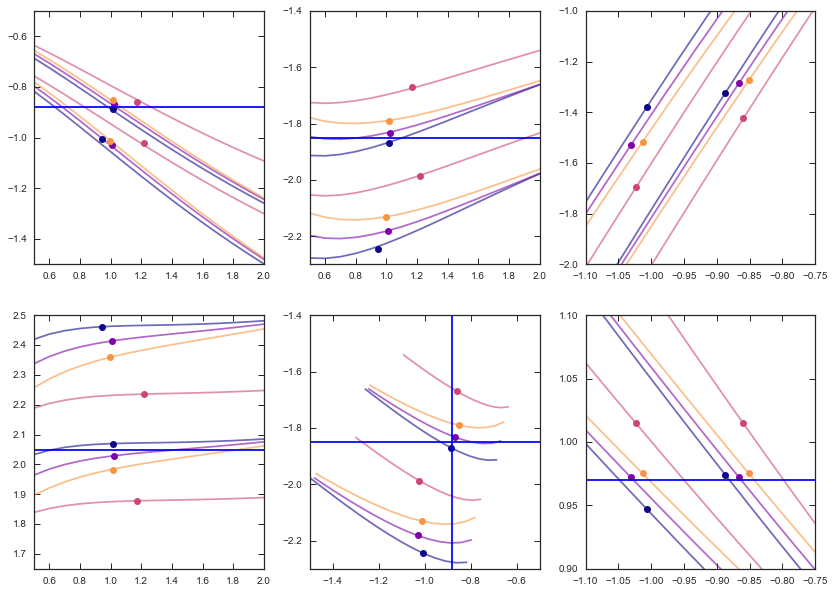

In [120]:
figsize(14,10)
cs= numpy.linspace(0.5,2.,16)
tvo= 240.
fns= ['pot%i_vo240_ro8_newd.dat' % ii for ii in range(20)]
cmap= cm.plasma
means.extend([-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000])
totnum= 4
for jj in range(totnum):
    with open(fns[jj],'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    fs= numpy.zeros((len(cs),3))
    for ii,c in enumerate(cs):
        pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
        fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
    cindx= numpy.argmin(numpy.fabs(cs-means3[jj]))
    subplot(2,3,1)
    plot(cs,fs[:,0],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],fs[cindx,0],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,2)
    plot(cs,fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,4)
    plot(cs,numpy.sqrt(numpy.sum(fs**2.,axis=1)),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means3[jj],numpy.sqrt(numpy.sum(fs**2.,axis=1))[cindx],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,5)
    plot(fs[:,0],fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,6)
    plot(fs[:,0],numpy.sqrt(2.*fs[:,0]/fs[:,1]),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],numpy.sqrt(2.*fs[cindx,0]/fs[cindx,1]),color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,3)
    plot(fs[:,0],3.6*fs[:,0]-fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],3.6*fs[cindx,0]-fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    
tvo= 220.
fns= ['pot%i_vo220_ro8_newd.dat' % ii for ii in range(20)]
totnum=4
for jj in range(totnum):
    with open(fns[jj],'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    fs= numpy.zeros((len(cs),3))
    for ii,c in enumerate(cs):
        pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
        fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
    cindx= numpy.argmin(numpy.fabs(cs-means[jj]))
    subplot(2,3,1)
    plot(cs,fs[:,0],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,0],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,2)
    plot(cs,fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,4)
    plot(cs,numpy.sqrt(numpy.sum(fs**2.,axis=1)),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],numpy.sqrt(numpy.sum(fs**2.,axis=1))[cindx],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,5)
    plot(fs[:,0],fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,6)
    plot(fs[:,0],numpy.sqrt(2.*fs[:,0]/fs[:,1]),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],numpy.sqrt(2.*fs[cindx,0]/fs[cindx,1]),color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,3)
    plot(fs[:,0],3.6*fs[:,0]-fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],3.6*fs[cindx,0]-fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    
subplot(2,3,1)
pyplot.axhline(-0.88)
xlim(0.5,2.)
ylim(-1.5,-0.5)
subplot(2,3,2)
pyplot.axhline(-1.85)
xlim(0.5,2.)
ylim(-2.3,-1.4)
subplot(2,3,4)
pyplot.axhline(numpy.sqrt((-1.85)**2.+(-0.88)**2.))
xlim(0.5,2.)
ylim(1.65,2.5)
subplot(2,3,5)
pyplot.axvline(-0.88)
pyplot.axhline(-1.85)
xlim(-1.5,-0.5)
ylim(-2.3,-1.4)
subplot(2,3,6)
pyplot.axhline(0.97)
xlim(-1.1,-0.75)
ylim(0.9,1.1)
subplot(2,3,3)
xlim(-1.1,-0.75)
ylim(-2.,-1.)

(0.85, 1.15)

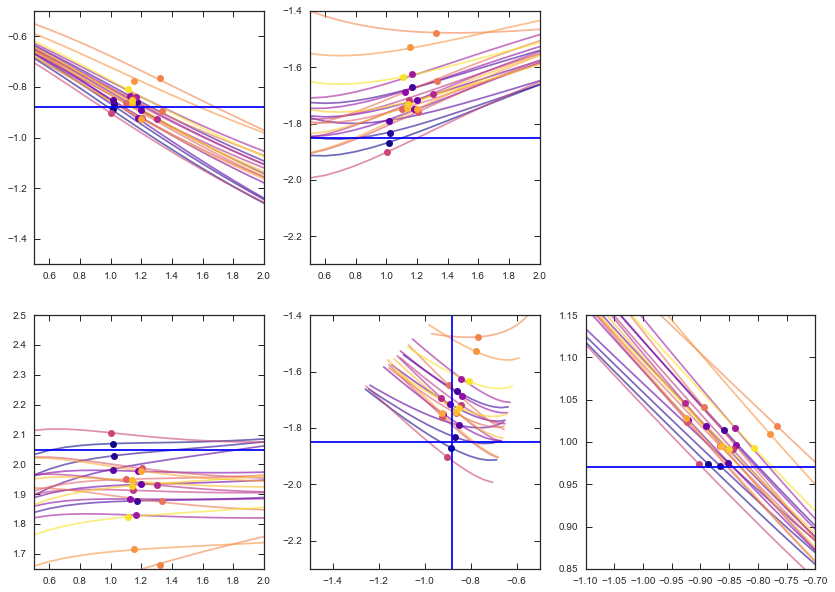

In [404]:
figsize(14,10)
cs= numpy.linspace(0.5,2.,16)
tvo= 220.
fns= ['pot%i_vo220_ro8_newd.dat' % ii for ii in range(20)]
cmap= cm.plasma
means.extend([-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000,-1000])
totnum= 20
for jj in range(totnum):
    with open(fns[jj],'rb') as savefile:
        line1= savefile.readline()
    potparams= [float(s) for s in (line1.split(':')[1].split(','))]
    fs= numpy.zeros((len(cs),3))
    for ii,c in enumerate(cs):
        pot= MWPotential2014Likelihood.setup_potential(potparams,c,False,False,ro,tvo)
        fs[ii]= numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo))
    cindx= numpy.argmin(numpy.fabs(cs-means[jj]))
    subplot(2,3,1)
    plot(cs,fs[:,0],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,0],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,2)
    plot(cs,fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,4)
    plot(cs,numpy.sqrt(numpy.sum(fs**2.,axis=1)),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(means[jj],numpy.sqrt(numpy.sum(fs**2.,axis=1))[cindx],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,5)
    plot(fs[:,0],fs[:,1],color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],fs[cindx,1],color=cmap(jj/float(totnum)),marker='o',zorder=2)
    subplot(2,3,6)
    plot(fs[:,0],numpy.sqrt(2.*fs[:,0]/fs[:,1]),color=cmap(jj/float(totnum)),zorder=1,alpha=0.6)
    plot(fs[cindx,0],numpy.sqrt(2.*fs[cindx,0]/fs[cindx,1]),color=cmap(jj/float(totnum)),marker='o',zorder=2)
subplot(2,3,1)
pyplot.axhline(-0.88)
xlim(0.5,2.)
ylim(-1.5,-0.5)
subplot(2,3,2)
pyplot.axhline(-1.85)
xlim(0.5,2.)
ylim(-2.3,-1.4)
subplot(2,3,4)
pyplot.axhline(numpy.sqrt((-1.85)**2.+(-0.88)**2.))
xlim(0.5,2.)
ylim(1.65,2.5)
subplot(2,3,5)
pyplot.axvline(-0.88)
pyplot.axhline(-1.85)
xlim(-1.5,-0.5)
ylim(-2.3,-1.4)
subplot(2,3,6)
pyplot.axhline(0.97)
xlim(-1.1,-0.7)
ylim(0.85,1.15)

In [268]:
import astropy.units as u
((18.5*u.kpc*2.05*u.km/u.s/u.Myr)**0.5).to(u.km/u.s)

<Quantity 192.56887081497206 km / s>

Is the Kuepper et al. potential a good fit?

In [31]:
from galpy import potential
import astropy.units as u
bestd= 23.12
bestpmoff= -0.2
vo,ro= 238.2, 8.29
pot= [potential.HernquistPotential(amp=3.4*10.**10.*u.Msun,a=0.7*u.kpc,ro=ro,vo=vo),
      potential.MiyamotoNagaiPotential(amp=10.**11.*u.Msun,a=6.5*u.kpc,b=0.26*u.kpc,ro=ro,vo=vo),
      potential.TriaxialNFWPotential(amp=1.81*10.**12.*u.Msun,a=37.*u.kpc,ro=ro,vo=vo)]
prog= Orbit([229.018,-0.124,bestd,-2.296+bestpmoff,-2.257+bestpmoff*2.257/2.296,-58.7],radec=True,ro=ro,vo=vo,
            solarmotion=[-11.1,24.,7.25])
#sdf_trailing_test= pal5_util.setup_sdf(pot,prog,0.4,5.,ro,vo,trailing_only=True)

In [35]:
MWPotential2014Likelihood.force_pal5(pot[:2],23.2,ro,vo)

(-0.28050730732772239, -0.72561859315246824, 0.0)

In [36]:
numpy.sqrt((-0.28050730732772239)**2.+(-0.72561859315246824)**2.)

0.77795031473277043

In [350]:
print potential.vcirc(pot,8.3*u.kpc)
print MWPotential2014Likelihood.force_pal5(pot,23.2,ro,vo)
print numpy.sqrt(numpy.sum(numpy.array(MWPotential2014Likelihood.force_pal5(pot,23.2,ro,vo))**2.))
np= potential.NFWPotential(mvir=1.85,conc=5.56,overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)
print np.mvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)/10.**12.
print np.conc(overdens=200.,wrtcrit=True,H=67.3)
print np.mass(np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False),0.,use_physical=False)\
    /(4.*numpy.pi/3.*np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False)**3.)\
    *bovy_conversion.dens_in_criticaldens(vo,ro,H=67.3)
print np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)

np= potential.NFWPotential(amp=1.81*10.**12.*u.Msun,a=37.*u.kpc,ro=ro,vo=vo)
print np.mvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)/10.**12.
print np.conc(overdens=200.,wrtcrit=True,H=67.3)
print np.mass(np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False),0.,use_physical=False)\
    /(4.*numpy.pi/3.*np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo,use_physical=False)**3.)\
    *bovy_conversion.dens_in_criticaldens(vo,ro,H=67.3)
print np.rvir(overdens=200.,wrtcrit=True,H=67.3,ro=ro,vo=vo)

222.794201542
(-1.0500696482418117, -2.3997867118852283, 0.0)
2.6194698946
1.85
5.56
200.0
259.980727222
2.28344470992
7.53724017154
200.0
278.877886347


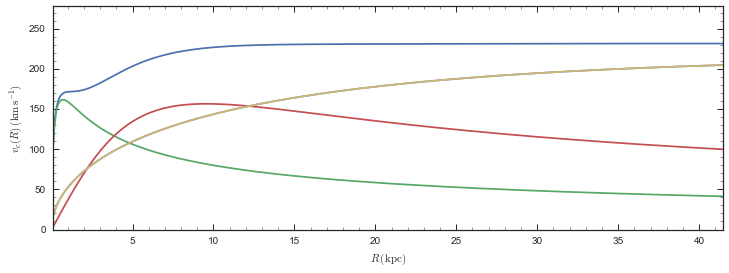

In [348]:
potential.plotRotcurve(pot)
potential.plotRotcurve(pot[0],overplot=True)
potential.plotRotcurve(pot[1],overplot=True)
potential.plotRotcurve(pot[2],overplot=True)
potential.plotRotcurve(np,overplot=True)

[-74.99314844 -33.37884293]
-108.371991368


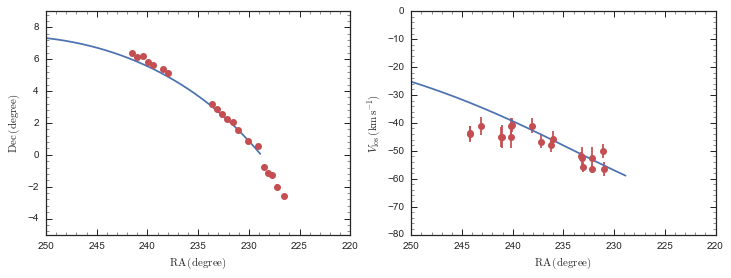

In [352]:
figsize(12,4)
subplot(1,2,1)
trackRADec_trailing= bovy_coords.lb_to_radec(\
    sdf_trailing_test._interpolatedObsTrackLB[:,0],
    sdf_trailing_test._interpolatedObsTrackLB[:,1],
    degree=True)
plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
subplot(1,2,2)
plot(trackRADec_trailing[:,0],
                    sdf_trailing_test._interpolatedObsTrackLB[:,3])
plot_data_add_labels(radeconly=False)
# Likelihood
tradec= bovy_coords.lb_to_radec(sdf_trailing_test._interpolatedObsTrackLB[:,0],
                                sdf_trailing_test._interpolatedObsTrackLB[:,1],
                                degree=True)
tra_in= numpy.zeros((1,len(sdf_trailing_test._interpolatedObsTrackLB[:,0]),2))
tra_in[0]= tradec
trvel_in= numpy.zeros((1,len(sdf_trailing_test._interpolatedObsTrackLB[:,0]),2))
trvel_in[0,:,0]= tradec[:,0]
trvel_in[0,:,1]= sdf_trailing_test._interpolatedObsTrackLB[:,3]
print pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                  tra_in,tra_in,
                                  trvel_in,trvel_in,
                                  numpy.array([0.]),
                                  numpy.array([0.]),None)[0,:3:2]
print numpy.sum(pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                  tra_in,tra_in,
                                  trvel_in,trvel_in,
                                  numpy.array([0.]),
                                  numpy.array([0.]),None)[0,:3:2])

## Commands to look at specific models

In [50]:
bestd= 1.02492378*22.
bestpmoff= -0.04157589
bestpmperpoff= 0.04206047
pmra= -2.296+bestpmoff+bestpmperpoff
pmdec= -2.257+bestpmoff*2.257/2.296+bestpmperpoff*-2.296/2.257
p_b15= [0.63504388,0.32861483,-1.03213156,-3.42043097,0.82830177]
tvo= 0.98671604*220.
sigv= 0.4*numpy.exp(0.04206047)
pot= MWPotential2014Likelihood.setup_potential(p_b15,0.6786754,False,False,ro,tvo)
prog= Orbit([229.018,-0.124,bestd,pmra,pmdec,-58.7],radec=True,ro=ro,vo=tvo,
            solarmotion=[-11.1,24.,7.25])
sdf_trailing_test,_= pal5_util.setup_sdf(pot,prog,sigv,10.,ro,tvo,trailing_only=True)

(0.6786754, 0.63337563692352206)


862.528709943 47.7131552962
(-0.71038259341714338, -1.7882045222102041, 0.0)
[  -5.27514532 -132.54280185  -13.01349527    0.            0.        ]
-18.3954551797


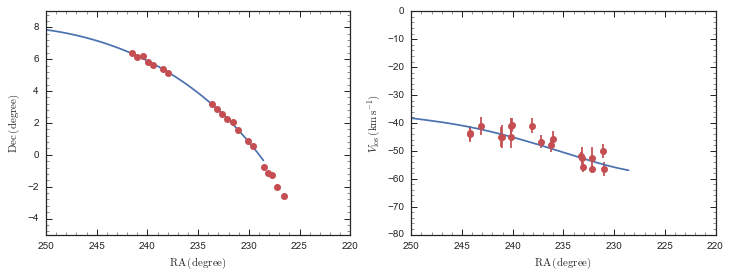

In [51]:
figsize(12,4)
subplot(1,2,1)
trackRADec_trailing= bovy_coords.lb_to_radec(\
    sdf_trailing_test._interpolatedObsTrackLB[:,0],
    sdf_trailing_test._interpolatedObsTrackLB[:,1],
    degree=True)
plot(trackRADec_trailing[:,0],trackRADec_trailing[:,1])
subplot(1,2,2)
plot(trackRADec_trailing[:,0],
                    sdf_trailing_test._interpolatedObsTrackLB[:,3])
plot_data_add_labels(radeconly=False)
# Likelihood
tradec= bovy_coords.lb_to_radec(sdf_trailing_test._interpolatedObsTrackLB[:,0],
                                sdf_trailing_test._interpolatedObsTrackLB[:,1],
                                degree=True)
tra_in= numpy.zeros((1,len(sdf_trailing_test._interpolatedObsTrackLB[:,0]),2))
tra_in[0]= tradec
trvel_in= numpy.zeros((1,len(sdf_trailing_test._interpolatedObsTrackLB[:,0]),2))
trvel_in[0,:,0]= tradec[:,0]
trvel_in[0,:,1]= sdf_trailing_test._interpolatedObsTrackLB[:,3]
print width_trailing(sdf_trailing_test), sdf_trailing_test.length(ang=True,coord='customra',threshold=0.3)
print MWPotential2014Likelihood.force_pal5(pot,23.46,ro,tvo)
print pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                  tra_in,tra_in,
                                  trvel_in,trvel_in,
                                  numpy.array([0.]),
                                  numpy.array([0.]),None)[0,:]
print numpy.sum(pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                  tra_in,tra_in,
                                  trvel_in,trvel_in,
                                  numpy.array([0.]),
                                  numpy.array([0.]),None)[0,:3:2])\
    -0.5*(pmra+2.296)**2./0.186**2.-0.5*(pmdec+2.257)**2./0.181**2.

In [48]:
reload(pal5_util)
pot_params= [0.63504388,0.32861483,-1.03213156,-3.42043097,0.82830177]
p= array([  0.67867542,   0.98671604,   1.02492378,  -0.04157589,
            0.04206047,   0.34089592, -18.28127818])
c= p[0]
tvo= p[1]*pal5_util._REFV0
dist= p[2]*22.
pmra= -2.296+p[3]+p[4]
pmdecpar= 2.257/2.296
pmdecperp= -2.296/2.257
pmdec= -2.257+p[3]*pmdecpar+p[4]*pmdecperp
sigv= 0.4*numpy.exp(p[5])
pal5varyc_like= pal5_util.predict_pal5obs(pot_params,c,singlec=True,
                                          dist=dist,pmra=pmra,pmdec=pmdec,
                                          ro=8.,vo=tvo,
                                          trailing_only=True,verbose=True,
                                          sigv=sigv,td=10.,nTrackChunks=21)
lnlike= pal5_util.pal5_lnlike(pos_radec,rvel_ra,
                                      pal5varyc_like[0],
                                      pal5varyc_like[1],
                                      pal5varyc_like[2],
                                      pal5varyc_like[3],
                                      pal5varyc_like[4],
                                      pal5varyc_like[5],
                                      pal5varyc_like[6])
print lnlike
print(lnlike[0,0]+lnlike[0,2]\
            -0.5*(pmra+2.296)**2./0.186**2.-0.5*(pmdec+2.257)**2./0.181**2.)

(0.67867542000000003, 0.63337565490186543)
[[ -5.27161263e+00  -1.00000000e+18  -1.97060250e+01   5.85192977e+01
    5.54447845e+01]]
-25.0844521969


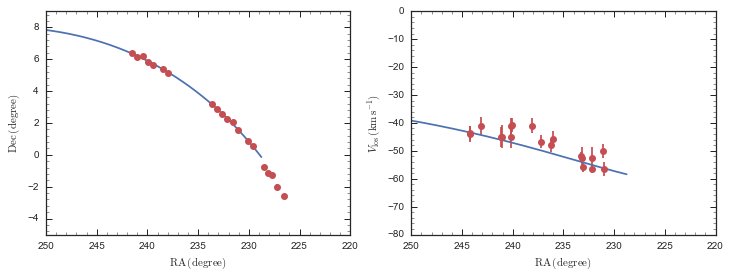

In [49]:
figsize(12,4)
subplot(1,2,1)
plot(pal5varyc_like[0][0,:,0],pal5varyc_like[0][0,:,1])
subplot(1,2,2)
plot(pal5varyc_like[2][0,:,0],pal5varyc_like[2][0,:,1])
plot_data_add_labels(radeconly=False)

In [46]:
numpy.log(sigv/.4)

NameError: name 'sigv' is not defined